In [1]:
import load_dataset
import config
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
import pandas as pd
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
import time

annotation_list = load_dataset.cocokeypoints_list_converter(str(config.ANNOTATION_DATA))
training_samples, valid_samples = load_dataset.train_test_split(
    annotation_list,
    config.TEST_SPLIT,
)

Training sample instances: 306
Validation sample instances: 6


shape[0]とは 306
総データ拡張数:  3060
/root/dataset/anime_face_landmark_20230912/canny_and_dilation/images/AnythingV5Ink_gitv1.5.4_0901_140034_2.jpg


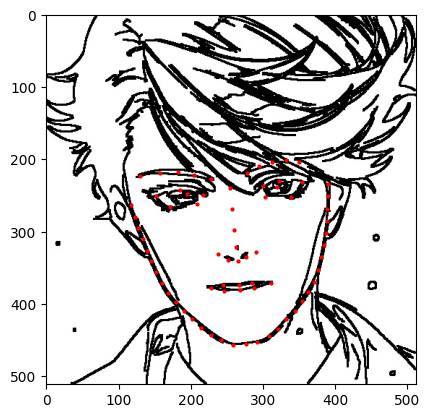

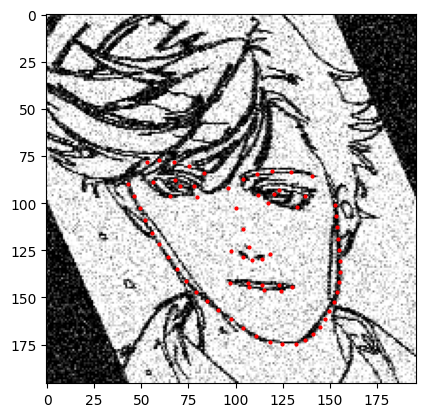

残りのデータ拡張数:  3059


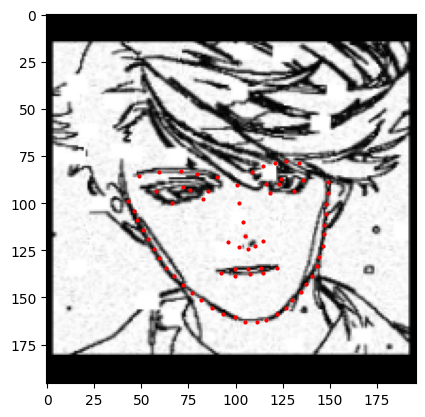

残りのデータ拡張数:  3058


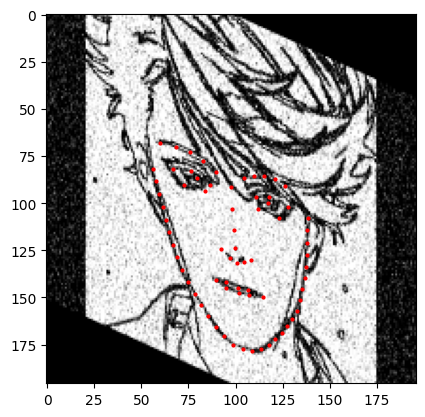

残りのデータ拡張数:  3057


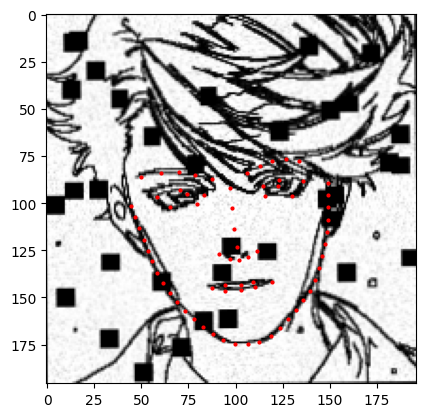

残りのデータ拡張数:  3056


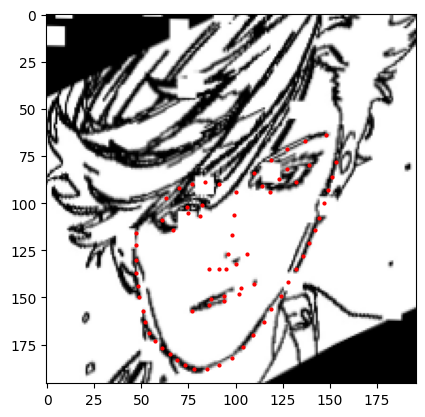

残りのデータ拡張数:  3055


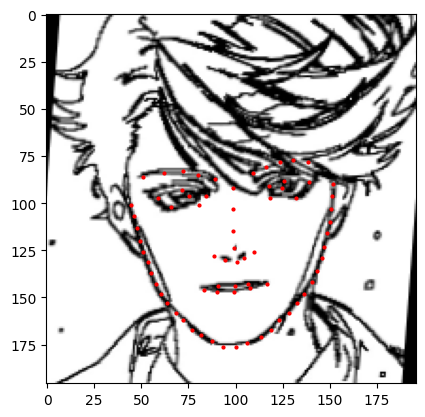

残りのデータ拡張数:  3054


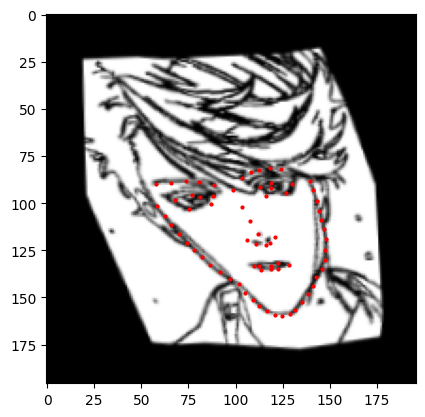

残りのデータ拡張数:  3053


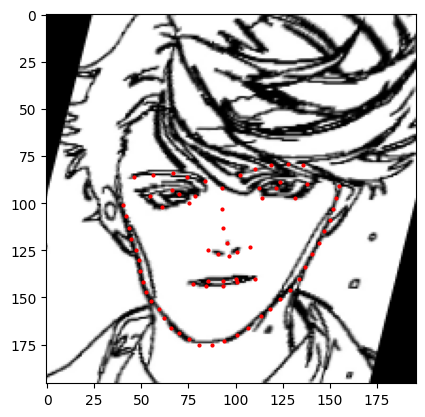

残りのデータ拡張数:  3052


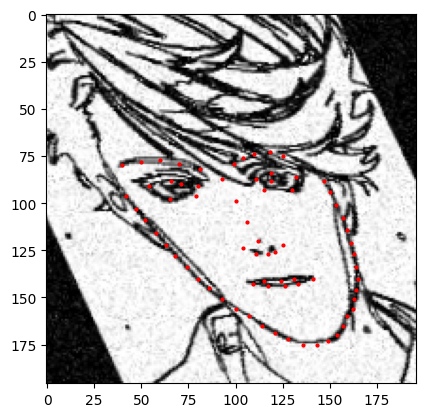

残りのデータ拡張数:  3051
/root/dataset/anime_face_landmark_20230912/canny_and_dilation/images/AnythingV5Ink_gitv1.5.4_0901_140221_1.jpg


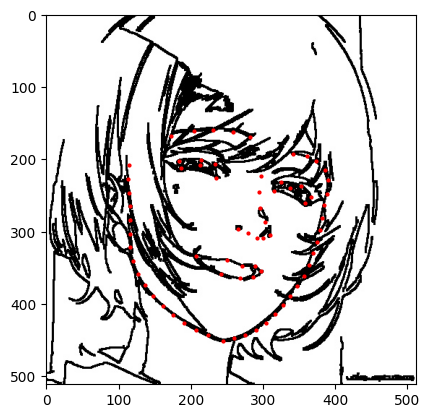

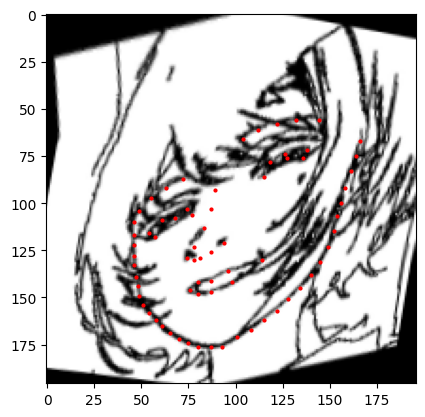

残りのデータ拡張数:  3050


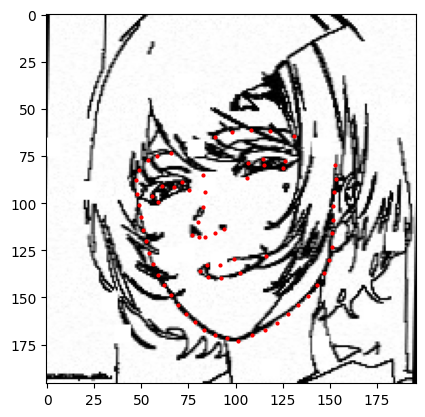

残りのデータ拡張数:  3049


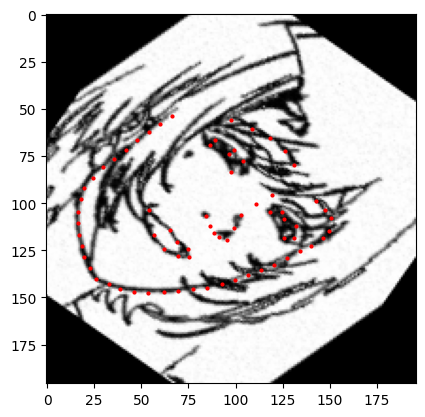

KeyboardInterrupt: 

In [2]:
# def AugmentFaceKeypointDataset(training_samples, data_path, aug_data_num, mix_augmentent = (3,5)):
# data_path = f"{config.DATASET_PATH}/Anime2Sketch"
data_path = f"{config.DATASET_PATH}/canny_and_dilation"
# /root/dataset/anime_face_landmark_20230912/images/images
# data_path = f"{config.DATASET_PATH}/only_canny"

data_set_list = []
resize_seq = iaa.Resize({"height": config.RESIZE, "width": config.RESIZE})
flip_sea = iaa.Fliplr(p=0.5)
mix_augmentent = (2,4)
aug_data_num = 10
# data_num = 1
print("shape[0]とは",training_samples.shape[0])

# print("len type",type(len(training_samples)))
total_data_count = int(training_samples.shape[0]) * int(aug_data_num)
print("総データ拡張数: ",total_data_count)
for data_num in range(training_samples[0:2].shape[0]):
    
    print(f"{data_path}/{training_samples.iloc[data_num, 0]}")
    image = cv2.imread(f"{data_path}/{training_samples.iloc[data_num, 0]}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_h, orig_w, _ =  image.shape
    # サイズ変更
    # image = cv2.resize(image, (512, 512))

    keypoints = training_samples.iloc[data_num][1:]
    keypoints = np.array(keypoints, dtype="float32")
    keypoints = keypoints.reshape(-1, 2)
    keypoints_per = keypoints * [1 / (orig_w), 1 / (orig_h)]

    for i in keypoints:
        plt.plot(i[0], i[1], 'o',color='red',markersize=2)

    plt.imshow(image)
    plt.show()
    plt.close()

    # print("オリジナル画像")
    if aug_data_num == 0:
        continue

    landmark_num = len(keypoints)
    kps = KeypointsOnImage(
        [Keypoint(x=keypoints[i][0], y=keypoints[i][1]) for i in range(0,landmark_num)],
        shape=image.shape,
    )

    image_resize, kps_resize = resize_seq(image=image, keypoints=kps)
    data_set_list.append([image_resize, keypoints_per])
    
    # seq = iaa.SomeOf(mix_augmentent, [
    #         iaa.Invert(1,per_channel=1),
    #         iaa.Add((-40, 40), per_channel=0.5),
    #         iaa.AdditiveGaussianNoise(scale=(0, 0.2*255)),
    #         iaa.Cutout(nb_iterations=(10, 40),size=0.05,cval=(0, 255),fill_per_channel=0.5),
    #         iaa.BlendAlpha([0.25, 0.75], iaa.MedianBlur(13)),

    #         iaa.Grayscale(alpha=(0.5, 1.0)),
    #         iaa.LogContrast(gain=(0.6, 1.4), per_channel=True),
    #         iaa.Affine(scale={"x": (0.7, 1.1), "y": (0.7, 1.1)}),
    #         iaa.Affine(rotate=(-45, 45)),

    #         iaa.Affine(translate_percent={"x": -0.20}, mode=ia.ALL, cval=(0, 255)),
    #         iaa.ShearX((-20, 20)),
    #         iaa.ShearY((-20, 20))
    #     ],random_order=True)
    # 白黒のパターン
    seq = iaa.SomeOf(mix_augmentent,[
        iaa.AdditiveGaussianNoise(scale=(0, 0.2*255)),
        iaa.Cutout(nb_iterations=(10, 35),size=0.05,cval=(0, 0),fill_per_channel=0.5),
        iaa.Cutout(nb_iterations=(10, 35),size=0.05,cval=(255,255),fill_per_channel=0.5),

        iaa.Affine(scale={"x": (0.7, 1.1), "y": (0.7, 1.1)}),
        iaa.Affine(rotate=(-45, 45)),

        iaa.ShearX((-30, 30)),
        iaa.ShearY((-30, 30)),
        iaa.PiecewiseAffine(scale=(0.03, 0.03))
    ],random_order=True)

    for aug_count in range(aug_data_num-1):
        # 画像を5割の確率で反転させる
        image_aug, kps_aug = flip_sea(image=image_resize, keypoints=kps_resize)
        image_aug, kps_aug = seq(image=image_aug, keypoints=kps_aug)
        
        
        
        keypoints = []
        for i in range(len(kps.keypoints)):
            before = kps.keypoints[i]
            after = kps_aug.keypoints[i]
            keypoints.append([after.x, after.y])
        keypoints = np.array(keypoints, dtype="float32")
        keypoints_per = keypoints * [1 / (orig_w), 1 / (orig_h)]
        image_after = kps_aug.draw_on_image(image_aug, size=0)

        # データ拡張を行った画像をリストに格納する
        data_set_list.append([image_after, keypoints_per])
        total_data_count -= 1
        plt.imshow(image_aug)
        # plt.imshow(image_aug, cmap='gray')
        for i in keypoints:
            plt.plot(i[0], i[1], 'o',color='red',markersize=2)
        plt.show()
        plt.close()
        time.sleep(1)

        print("残りのデータ拡張数: ",total_data_count)

In [35]:
data_set_list

[[array([[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         ...,
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255